<a href="https://colab.research.google.com/github/sidrusiya/AILA_Tasks/blob/main/AILA_Task1_XLNet_XL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Dataset and Dependencies**

In [1]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import seaborn as sns
import gensim
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

False

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
!pip3 install tensorflow_text
import tensorflow_text
!pip install -q tf-models-official
!pip install -q -U tensorflow-text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_hub as hub
import tensorflow_text as tf_text

     |████████████████████████████████| 4.9 MB 5.5 MB/s 
     |████████████████████████████████| 1.8 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 51.6 MB/s 
     |████████████████████████████████| 352 kB 50.4 MB/s 
     |████████████████████████████████| 47.6 MB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 36.3 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 99 kB 8.4 MB/s 
     |████████████████████████████████| 213 kB 45.8 MB/s 
     |████████████████████████████████| 1.2 MB 37.9 MB/s 


In [3]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1/'
list_dir = os.listdir(PATH)
text = []
labels = []
for file in list_dir:
    file_path = PATH + file
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])

data = {'Text': text, "labels": labels}
dataset1 = pd.DataFrame(data=data)

Mounted at /content/drive


In [4]:
dataset1.head()

,Text,labels
0,The appellant who was arraigned as Accused 2 w...,Facts
1,"The allegations against the accused, inter ali...",Facts
2,Bindula Devi was married to Accused 1 Jaipraks...,Facts
3,The appellant and Accused 3 Shakun Devo Yadav ...,Facts
4,Accused 4 Dani Dutta Yadav is their father and...,Facts


In [5]:
dataset1.shape

(11285, 2)

# **Data Preprocessing**

In [6]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [7]:
event_types_dict = {}
for num, name in enumerate(list(dataset1['labels'].unique())):
    event_types_dict[name] = num
    # print(name, " : ", num)

event_types_dict

event_types_dict_inverse = {k:v for v,k in event_types_dict.items()}
print(event_types_dict)
print( event_types_dict_inverse)

{'Facts': 0, 'Ruling by Lower Court': 1, 'Argument': 2, 'Precedent': 3, 'Ratio of the decision': 4, 'Statute': 5, 'Ruling by Present Court': 6}
{0: 'Facts', 1: 'Ruling by Lower Court', 2: 'Argument', 3: 'Precedent', 4: 'Ratio of the decision', 5: 'Statute', 6: 'Ruling by Present Court'}


In [8]:
def text_to_numerical_category(name):
    num = event_types_dict[name]
    return num

print(text_to_numerical_category('Facts'))
dataset1['num_labels'] = dataset1['labels'].apply(text_to_numerical_category)
dataset1

0


,Text,labels,num_labels
0,The appellant who was arraigned as Accused 2 w...,Facts,0
1,"The allegations against the accused, inter ali...",Facts,0
2,Bindula Devi was married to Accused 1 Jaipraks...,Facts,0
3,The appellant and Accused 3 Shakun Devo Yadav ...,Facts,0
4,Accused 4 Dani Dutta Yadav is their father and...,Facts,0
...,...,...,...
11280,"Suffice it to state that the appellant,as a fa...",Ratio of the decision,4
11281,"The High Court,in our view,declined,for good r...",Ratio of the decision,4
11282,We are also not persuaded to take a different ...,Ratio of the decision,4
11283,"In these circumstances,we are of the view that...",Ratio of the decision,4


# **Lowering the characters and removing the stopwords**

In [9]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [10]:
nltk.download('stopwords')
import sys
text = []
lem_text = []
for i in dataset1.index:
    dataset1['Text'][i] = remove_size(dataset1['Text'][i])
    dataset1['Text'][i] = remove_months(dataset1['Text'][i])
    dataset1['Text'][i] = remove_nums(dataset1['Text'][i])
    dataset1['Text'][i] = remove_comma(dataset1['Text'][i])
    temp = dataset1['Text'][i].lower().split()
    clean = [word for word in temp if word not in stopwords.words('english')]
    clean = " ".join(clean)
    text.append(clean)
    lem_text.append(clean)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value

# **Tokenization**

In [11]:
for i in range(len(text)):
    text[i] = text[i].split()

In [12]:
for i in range(len(lem_text)):
    lem_text[i] = lem_text[i].split()

# **Stemmation**

In [13]:
from nltk import PorterStemmer
st = PorterStemmer()
for i in range(len(text)):
    text[i] = [st.stem(word) for word in text[i]]

# **Lemmatization**

In [14]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet') 
lemmatizer = WordNetLemmatizer()

for i in range(len(lem_text)):
    lem_text[i] = [lemmatizer.lemmatize(word) for word in lem_text[i]]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


# **Recombining Tokens**

In [15]:
for i in range(len(text)):
    text[i] = " ".join(text[i])

text[0]

'appel arraign accus tri along five accus offenc punish section read ss. ipc st addit session judg madhepura.'

In [16]:
for i in range(len(lem_text)):
    lem_text[i] = " ".join(lem_text[i])

lem_text[0]

'appellant arraigned accused tried along five accused offence punishable section read ss. ipc st additional session judge madhepura.'

In [17]:
dataset1['lem_text'] = np.array(lem_text)
dataset1['stem_text'] = np.array(text)

dataset1

,Text,labels,num_labels,lem_text,stem_text
0,The appellant who was arraigned as Accused wa...,Facts,0,appellant arraigned accused tried along five a...,appel arraign accus tri along five accus offen...
1,The allegations against the accused inter alia...,Facts,0,allegation accused inter alia subjected one bi...,alleg accus inter alia subject one bindula dev...
2,Bindula Devi was married to Accused Jaipraksh...,Facts,0,bindula devi married accused jaipraksh yadav.,bindula devi marri accus jaipraksh yadav.
3,The appellant and Accused Shakun Devo Yadav a...,Facts,0,appellant accused shakun devo yadav brother ac...,appel accus shakun devo yadav brother accus ja...
4,Accused Dani Dutta Yadav is their father and ...,Facts,0,accused dani dutta yadav father accused satya ...,accus dani dutta yadav father accus satya bham...
...,...,...,...,...,...
11280,Suffice it to state that the appellantas a fac...,Ratio of the decision,4,suffice state appellantas facthad used trade m...,suffic state appellanta facthad use trade mark...
11281,The High Courtin our viewdeclinedfor good reas...,Ratio of the decision,4,high courtin viewdeclinedfor good reasonsto re...,high courtin viewdeclinedfor good reasonsto re...
11282,We are also not persuaded to take a different ...,Ratio of the decision,4,also persuaded take different view high court,also persuad take differ view high court
11283,In these circumstanceswe are of the view that ...,Ratio of the decision,4,circumstanceswe view high court properly exerc...,circumstancesw view high court properli exerci...


In [18]:
dataset1.labels.value_counts()

Ratio of the decision      4211
Facts                      2622
Precedent                  1787
Argument                    939
Statute                     902
Ruling by Lower Court       483
Ruling by Present Court     341
Name: labels, dtype: int64

In [19]:
dataset1.drop_duplicates(['lem_text']).labels.value_counts()

Ratio of the decision      4146
Facts                      2566
Precedent                  1754
Argument                    905
Statute                     867
Ruling by Lower Court       476
Ruling by Present Court     276
Name: labels, dtype: int64

# **Handling Imbalanced Dataset**

In [20]:
from sklearn.utils import shuffle

lemm = []
labels = []
THRESH_1 = 1500
THRESH_2 = 500

for group in dataset1.labels.unique():
    if len(dataset1.groupby('labels').get_group(group).Text.unique()) > THRESH_1:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        labels += ([group]*2*len(list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique()))))

    elif len(dataset1.groupby('labels').get_group(group).Text.unique()) > THRESH_2:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        labels += ([group]*3*len(list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique()))))
    else:
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        lemm += (list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique())))
        labels += ([group]*5*len(list(shuffle(dataset1.groupby('labels').get_group(group).Text.unique()))))

In [21]:
len(lemm)

26395

In [22]:
balanced_df = pd.DataFrame({'Text' : lemm, 'Labels': labels})

In [23]:
balanced_df.Labels.value_counts()

Ratio of the decision      8382
Facts                      5204
Precedent                  3540
Argument                   2769
Statute                    2640
Ruling by Lower Court      2410
Ruling by Present Court    1450
Name: Labels, dtype: int64

In [24]:
balanced_df['NumLabel'] = balanced_df.Labels.apply(text_to_numerical_category)

In [25]:
balanced_df.head()

,Text,Labels,NumLabel
0,Its operations were confined to the municipal ...,Facts,0
1,Under the said Agreement M/s,Facts,0
2,Wordy altercations ensued between the parties ...,Facts,0
3,After completion of investigation charge sheet...,Facts,0
4,I in respect of each head of the offences with...,Facts,0


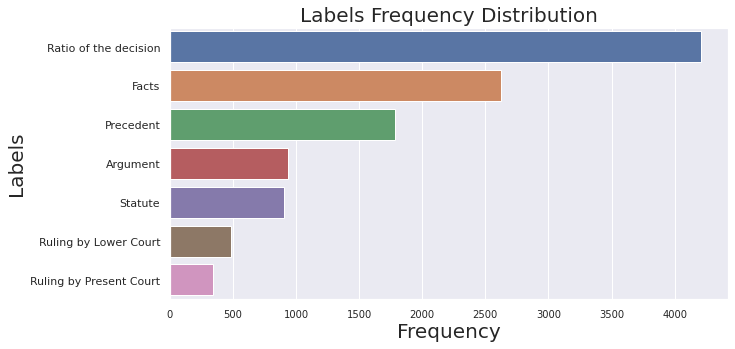

In [26]:
sns.set_theme(style="darkgrid")
x = dataset1['labels'].value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Labels Frequency Distribution", fontsize=20)
plt.ylabel('Labels', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

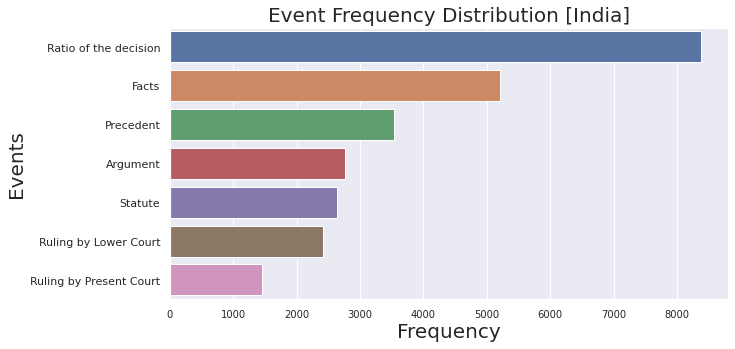

In [27]:
sns.set_theme(style="darkgrid")
x = balanced_df.Labels.value_counts()
y = x.index
plt.figure(figsize=(10, 5))
g = sns.barplot(x=x, y=y)
plt.title("Event Frequency Distribution [India]", fontsize=20)
plt.ylabel('Events', fontsize= 20)
plt.yticks(fontsize=11)
plt.xlabel('Frequency', fontsize=20)
plt.xticks(fontsize=10)
plt.show()

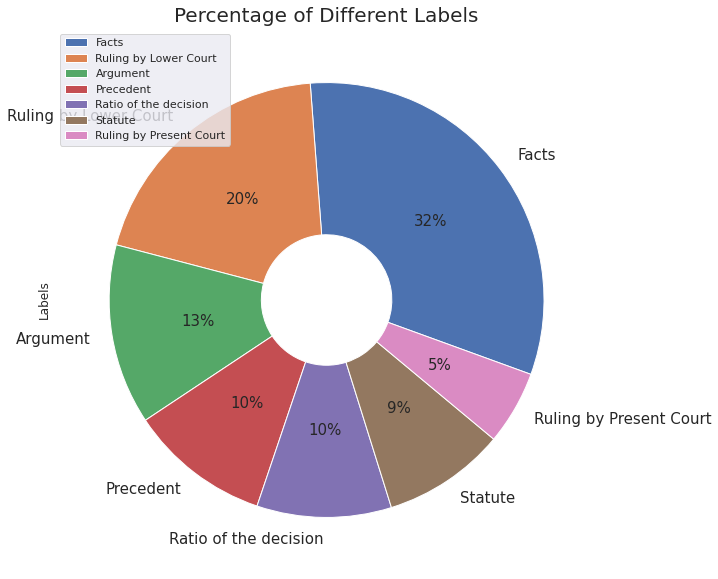

In [28]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
balanced_df.Labels.value_counts().plot(kind='pie', labels= balanced_df.Labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

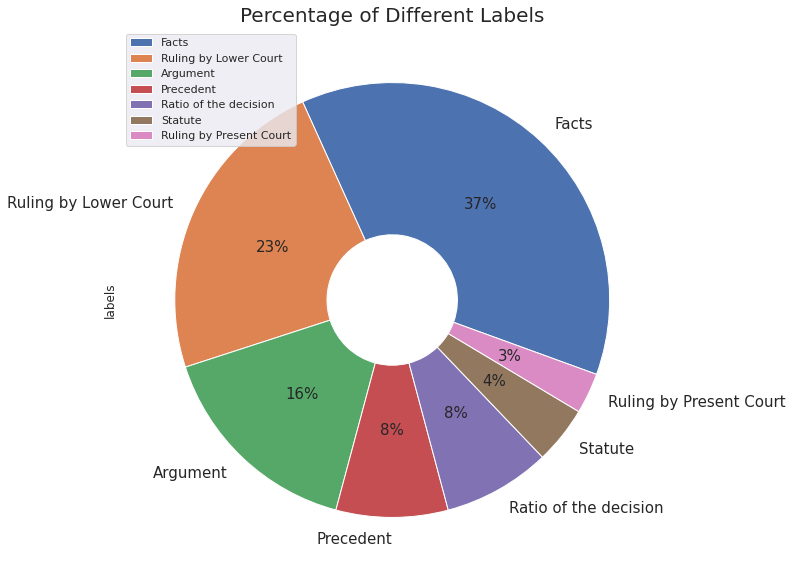

In [29]:
plt.figure(figsize=(30,10))
plt.title('Percentage of Different Labels', fontsize=20)
dataset1.labels.value_counts().plot(kind='pie', labels= dataset1.labels.unique(),
                              wedgeprops=dict(width=.7), autopct='%1.0f%%', startangle= -20, 
                              textprops={'fontsize': 15})
plt.legend(loc='upper left')
plt.show()

# **XL-Net**

In [30]:
max_classes = len(balanced_df.Labels.unique())
max_length = 128

In [31]:
!pip3 install transformers
!pip install sentencepiece
from transformers import AutoTokenizer, TFXLNetModel

# Same as before

checkpoint = "xlnet-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, max_length=max_length)

     |████████████████████████████████| 3.1 MB 5.1 MB/s 
     |████████████████████████████████| 61 kB 495 kB/s 
     |████████████████████████████████| 895 kB 52.3 MB/s 
     |████████████████████████████████| 3.3 MB 35.6 MB/s 


Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/779k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

In [32]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 3
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
batch_size = 64

# num_train_steps =  len((balanced_df.NumLabel) // batch_size) * EPOCHS
# lr_scheduler = PolynomialDecay(initial_learning_rate=5e-5,
#                                end_learning_rate=0.,
#                                decay_steps=num_train_steps
#                                )

from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=5e-5)

In [33]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
result = shuffle(balanced_df)

In [34]:
X_train, X_test, Y_train, Y_test = train_test_split(result.Text, result.NumLabel, test_size = 0.1, random_state = 42, stratify =result.NumLabel)

In [35]:
max_classes = len(balanced_df.Labels.unique())
print(max_classes)

7


In [36]:
%%time
encoded_labels_train = to_categorical(Y_train, num_classes=max_classes)
encoded_labels_test = to_categorical(Y_test, num_classes=max_classes)

CPU times: user 2.53 ms, sys: 78 µs, total: 2.6 ms
Wall time: 2.03 ms


In [37]:
def XLNet_encode(data,maximum_length) :
  input_ids = []
  attention_masks = []
  

  for i in tqdm(range(len(data))):
      encoded = tokenizer.encode_plus(
        
        data[i],
        add_special_tokens=True,
        max_length=maximum_length,
        pad_to_max_length=True,
        return_attention_mask=True,
        
      )
      
      input_ids.append(encoded['input_ids'])
      attention_masks.append(encoded['attention_mask'])
  return np.array(input_ids),np.array(attention_masks)

In [38]:
%%time
# train_inputs,train_attention_masks = XLNet_encode(list(X_train), max_length)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [39]:
def get_inputs(tweets, tokenizer, max_len=120):
    """ Gets tensors from text using the tokenizer provided"""
    inps = [tokenizer.encode_plus(t, max_length=max_len, pad_to_max_length=True, add_special_tokens=True) for t in tweets]
    inp_tok = np.array([a['input_ids'] for a in inps])
    ids = np.array([a['attention_mask'] for a in inps])
    segments = np.array([a['token_type_ids'] for a in inps])
    return inp_tok, ids, segments

In [40]:
%%time
train_inp_tok, train_attention_masks, segments = get_inputs(X_train, tokenizer)
test_inp_tok, test_attention_masks, segments = get_inputs(X_test, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


CPU times: user 7.61 s, sys: 376 ms, total: 7.99 s
Wall time: 7.96 s


In [41]:
print(train_inp_tok.shape, test_inp_tok.shape)

(23755, 120) (2640, 120)


In [42]:
print(f'Number of Samples in Training Set : {len(X_train)} Number of Samples in Validation Set: {len(X_test)} ')

Number of Samples in Training Set : 23755 Number of Samples in Validation Set: 2640 


In [43]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
!mkdir checkpoints

MyCheckpoint = ModelCheckpoint('XLNet-base.h5',
                               monitor = 'val_categorical_accuracy',
                               verbose = 1,
                               save_best_only = True,
                               mode='auto',
                               save_weights_only = True)

MyEarlyStopping = EarlyStopping(patience =1,
                                monitor='val_categorical_accuracy',
                                restore_best_weights = True,
                                verbose = 1)

import os
os.path.exists('/content/checkpoints')

True

In [44]:
from sklearn.utils import class_weight
class_weights_array = class_weight.compute_class_weight(class_weight = 'balanced'
                                               ,classes = np.unique(balanced_df.NumLabel)
                                               ,y = balanced_df.NumLabel)

class_weights_array

array([0.72457999, 1.56461174, 1.36176031, 1.06517353, 0.44985854,
       1.42830087, 2.60049261])

In [45]:
class_weights = {i : class_weights_array[i] for i in range(len(class_weights_array))}
class_weights

{0: 0.7245799934116613,
 1: 1.564611736810907,
 2: 1.3617603054222773,
 3: 1.0651735270379339,
 4: 0.4498585404097215,
 5: 1.4283008658008658,
 6: 2.6004926108374384}

In [46]:
# !pip install tensorflow_addons
# import tensorflow_addons as tfa

# macro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='macro')
# micro_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='micro')
# weighted_f1 = tfa.metrics.F1Score(num_classes=max_classes, average='weighted')
precision = tf.metrics.Precision()
recall = tf.metrics.Recall()
categorical_accuracry = tf.metrics.CategoricalAccuracy()

class F1_metric(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        # Initialize our metric by initializing the two metrics it's based on:
        # Precision and Recall
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Update our metric by updating the two metrics it's based on
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
        # To get the F1 result, we compute the harmonic mean of the current
        # precision and recall
        return 2 / ((1 / self.precision.result()) + (1 / self.recall.result())) 

F1Score = F1_metric()
metrics = [categorical_accuracry, F1Score]

In [47]:
def create_model(xlnet_model):
  input_ids = tf.keras.Input(shape=(max_length,),dtype='int32')

  attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')
  
#   output = xlnet_model([input_ids,attention_masks])
  output = xlnet_model(input_ids)
  output = output[0]
  output = tf.squeeze(output[:, -1:, :], axis=1)
  
#   output = tf.keras.layers.Dense(128,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

#   output = tf.keras.layers.Dense(64,activation='relu',)(output)
#   output = tf.keras.layers.Dropout(0.2)(output)
#   output = tf.keras.layers.BatchNormalization()(output)

  output = tf.keras.layers.Dense(32,activation='relu')(output)
  output = tf.keras.layers.Dropout(0.2)(output)
  
  output = tf.keras.layers.Dense(units=max_classes,activation='softmax')(output)
  model = tf.keras.models.Model(inputs = input_ids,outputs = output)
  model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)
  return model

In [48]:
def create_xlnet(mname):
    """ Creates the model. It is composed of the XLNet main block and then
    a classification head its added
    """
    # Define token ids as inputs
    word_inputs = tf.keras.Input(shape=(120,), name='word_inputs', dtype='int32')
    attention_masks = tf.keras.Input(shape=(120,),dtype='int32')
    # Call XLNet model
    xlnet = TFXLNetModel.from_pretrained(mname)
    xlnet_encodings = xlnet(word_inputs, attention_masks)[0]

    # CLASSIFICATION HEAD 
    # Collect last step from last hidden state (CLS)
    doc_encoding = tf.squeeze(xlnet_encodings[:, -1:, :], axis=1)
    # Apply dropout for regularization
    doc_encoding = tf.keras.layers.Dropout(.1)(doc_encoding)
    # Final output 
    outputs = tf.keras.layers.Dense(units=max_classes,activation='softmax')(doc_encoding)

    # Compile model
    model = tf.keras.Model(inputs=[word_inputs, attention_masks], outputs=[outputs])
    model.compile(optimizer= opt,
              loss= loss,
              metrics = metrics)

    return model

In [49]:
from transformers import TFXLNetModel
xlnet_model = TFXLNetModel.from_pretrained(checkpoint)
# from transformers import TFAutoModelForSequenceClassification
# model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=max_classes)

model = create_xlnet(checkpoint)
# model.layers[2].trainable = False
model.summary()

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.
Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel fro

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word_inputs (InputLayer)       [(None, 120)]        0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 120)]        0           []                               
                                                                                                  
 tfxl_net_model_1 (TFXLNetModel  TFXLNetModelOutput(  116718336  ['word_inputs[0][0]',            
 )                              last_hidden_state=(               'input_1[0][0]']                
                                None, 120, 768),                                                  
                                 mems=((120, None,                                            

In [50]:
%%time
history = model.fit([train_inp_tok, train_attention_masks], encoded_labels_train, 
                    validation_data=([test_inp_tok, test_attention_masks], encoded_labels_test),
                    epochs = 3,
                    batch_size = 32,    
                    verbose = 1,
                    class_weight=class_weights,
                    callbacks = [MyCheckpoint, MyEarlyStopping]
                    )

Epoch 1/3
743/743 [==============================] - ETA: 0s - loss: 1.2812 - categorical_accuracy: 0.4850 - f1_score: 0.4290
Epoch 00001: val_categorical_accuracy improved from -inf to 0.70038, saving model to XLNet-base.h5
743/743 [==============================] - 1956s 3s/step - loss: 1.2812 - categorical_accuracy: 0.4850 - f1_score: 0.4290 - val_loss: 0.8321 - val_categorical_accuracy: 0.7004 - val_f1_score: 0.6877
Epoch 2/3
743/743 [==============================] - ETA: 0s - loss: 0.5996 - categorical_accuracy: 0.7110 - f1_score: 0.7048
Epoch 00002: val_categorical_accuracy improved from 0.70038 to 0.80341, saving model to XLNet-base.h5
743/743 [==============================] - 1921s 3s/step - loss: 0.5996 - categorical_accuracy: 0.7110 - f1_score: 0.7048 - val_loss: 0.5794 - val_categorical_accuracy: 0.8034 - val_f1_score: 0.7979
Epoch 3/3
743/743 [==============================] - ETA: 0s - loss: 0.3146 - categorical_accuracy: 0.8374 - f1_score: 0.8368
Epoch 00003: val_catego

# **Testing**

In [69]:
drive.mount('/content/drive')
PATH = '/content/drive/MyDrive/Task1_Test/'
list_dir = os.listdir(PATH)
text = []
labels = []
sentid = []
i=0
for file in list_dir:
    file_path = PATH + file
    j=1
    i=i+1
    with open(file_path, 'r') as f:
        for line in f:
            line = line.split(sep='\t')
            text.append(line[0])
            labels.append(line[1][:-1])
            sentid.append("d"+str(i)+"_s"+str(j))
            j=j+1

data = {'ID': sentid, 'Text': text, "labels": labels}
test_file = pd.DataFrame(data=data)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# Remove Excess [Size:: ] from EoS
def remove_size(text):
	result = re.search("\[size", text)
	if result is not None:
		text = text[:result.start()]
	return text.strip()

months = ['january', 'jan', 'feb', 'mar', 'apr', 'aug', 'sept', 'oct', 'nov', 'dec', 'feburary', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'on']
def remove_months(text):
    text = text.split()
    text = [word for word in text if word.lower() not in set(months)]
    text = ' '.join(text)
    return text

def remove_nums(text):
    result = re.sub(r'[0-9+]', '', text)
    return result

def remove_comma(text):
    result = re.sub(r',', '', text)
    return result

In [71]:
def text_cleaning(text):
    text = remove_size(text)
    text = remove_nums(text)
    text = remove_months(text)
    text = remove_comma(text)
    return text.strip().lower()

test_file['processed'] = test_file['Text'].apply(text_cleaning)

In [72]:
test_file

,ID,Text,labels,processed
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,these two criminal appeals are preferred by th...
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application no. of and of passed by the learne...
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,the respondent no. shyam vithalrao devkatta fi...
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process was issued by th...
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,of these accused four approached the bombay hi...
...,...,...,...,...
692,d10_s60,"Applying the above principles, it is clear fro...",Ratio of the decision,applying the above principles it is clear from...
693,d10_s61,Kalawati was last seen in the company of the a...,Ratio of the decision,kalawati was last seen in the company of the a...
694,d10_s62,"After his arrest, the production, by the appel...",Ratio of the decision,after his arrest the production by the appella...
695,d10_s63,"To conclude, the appellant has been rightly co...",Ruling by Present Court,to conclude the appellant has been rightly con...


In [55]:
lemmatizer = WordNetLemmatizer()
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
def lemmatizing_headlines(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in set(stopwords.words('english'))]
    return ' '.join(tokens).strip()

#test_file['processed'] = test_file['processed'].apply(lemmatizing_headlines)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [73]:
test_file.head()

,ID,Text,labels,processed
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,these two criminal appeals are preferred by th...
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application no. of and of passed by the learne...
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,the respondent no. shyam vithalrao devkatta fi...
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process was issued by th...
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,of these accused four approached the bombay hi...


In [74]:
final_test_inputs, final_test_attention_masks, segments = get_inputs(test_file.processed, tokenizer)
y_preds = np.argmax(model.predict([final_test_inputs, final_test_attention_masks]), axis=1)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [75]:
y_preds

array([1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 4, 0, 5, 1, 1, 1,
       0, 2, 2, 2, 0, 2, 0, 1, 5, 5, 5, 5, 5, 3, 0, 4, 0, 4, 4, 1, 4, 5,
       4, 5, 4, 3, 1, 0, 1, 4, 4, 4, 4, 5, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 3, 3, 4, 3, 3, 4, 1, 3, 3, 3, 4, 3, 3, 3, 1, 3, 4, 3,
       3, 4, 0, 5, 4, 3, 3, 3, 3, 3, 3, 3, 4, 3, 6, 3, 3, 3, 2, 1, 2, 3,
       6, 6, 6, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 3, 1, 2, 0, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 2, 0, 2, 2, 2, 4, 5, 0, 0, 0,
       0, 0, 2, 0, 3, 0, 2, 0, 5, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 0, 3, 0, 0, 0, 0, 4, 4, 4, 0, 4, 3, 3, 3, 0,
       3, 0, 4, 4, 4, 4, 2, 0, 0, 0, 6, 6, 6, 6, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 3, 3, 3, 4, 4, 0, 0, 4, 3, 3,
       3, 4, 4, 5, 5, 5, 5, 4, 0, 5, 5, 5, 4, 3, 6, 6, 6, 6, 1, 0, 1, 0,
       0, 1, 6, 0, 0, 0, 0, 4, 0, 0, 4, 1, 1, 4, 2, 0, 0, 0, 0, 0, 0, 4,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 0, 0, 0,

In [76]:
test_file['pred-labels'] = y_preds

In [77]:
test_file.head()

,ID,Text,labels,processed,pred-labels
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,these two criminal appeals are preferred by th...,1
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application no. of and of passed by the learne...,1
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,the respondent no. shyam vithalrao devkatta fi...,0
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process was issued by th...,0
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,of these accused four approached the bombay hi...,1


In [78]:
def num_to_text_labels(num):
    text = event_types_dict_inverse[num]
    return text

test_file['text_labels'] = test_file['pred-labels'].apply(num_to_text_labels)

In [79]:
test_file

,ID,Text,labels,processed,pred-labels,text_labels
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,these two criminal appeals are preferred by th...,1,Ruling by Lower Court
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application no. of and of passed by the learne...,1,Ruling by Lower Court
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,the respondent no. shyam vithalrao devkatta fi...,0,Facts
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process was issued by th...,0,Facts
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,of these accused four approached the bombay hi...,1,Ruling by Lower Court
...,...,...,...,...,...,...
692,d10_s60,"Applying the above principles, it is clear fro...",Ratio of the decision,applying the above principles it is clear from...,4,Ratio of the decision
693,d10_s61,Kalawati was last seen in the company of the a...,Ratio of the decision,kalawati was last seen in the company of the a...,0,Facts
694,d10_s62,"After his arrest, the production, by the appel...",Ratio of the decision,after his arrest the production by the appella...,4,Ratio of the decision
695,d10_s63,"To conclude, the appellant has been rightly co...",Ruling by Present Court,to conclude the appellant has been rightly con...,6,Ruling by Present Court


                         precision    recall  f1-score   support

               Argument       0.69      0.77      0.73        56
                  Facts       0.54      0.64      0.59       154
              Precedent       0.32      0.65      0.43        79
  Ratio of the decision       0.73      0.29      0.42       314
  Ruling by Lower Court       0.18      0.56      0.27        25
Ruling by Present Court       0.77      0.82      0.80        40
                Statute       0.44      0.76      0.56        29

               accuracy                           0.51       697
              macro avg       0.53      0.64      0.54       697
           weighted avg       0.61      0.51      0.50       697



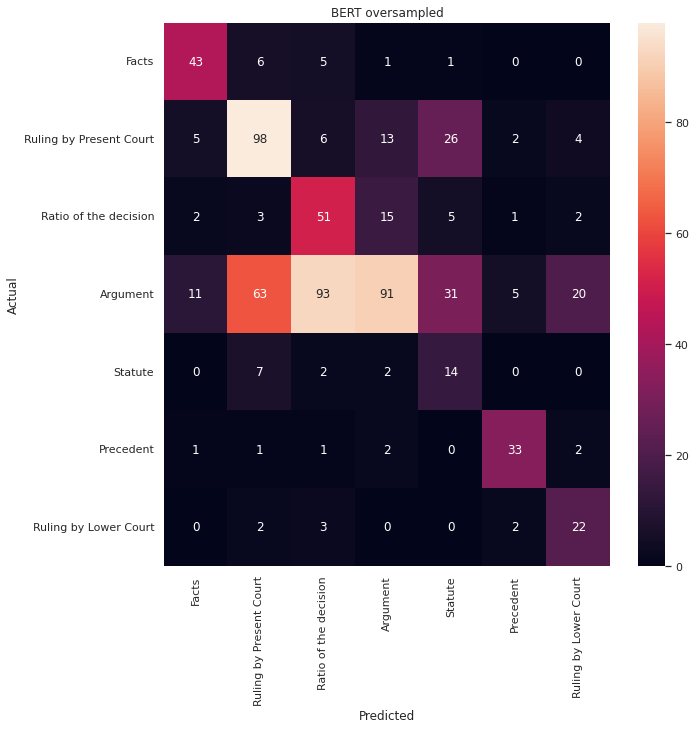

In [80]:
from sklearn.metrics import classification_report
print(classification_report(test_file.labels,test_file.text_labels))

import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(list(test_file.labels), list(test_file['text_labels']))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=set(test_file.labels), yticklabels=set(test_file.labels))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('BERT oversampled')
plt.show()

In [81]:
run=["nit_agartala_nlp_team_1"]*697
test_file['run_id']=run
test_file.rename(columns = {'ID':'docid_sentid', 'text-labels':'label'}, inplace = True)
test_file

,docid_sentid,Text,labels,processed,pred-labels,text_labels,run_id
0,d1_s1,These two Criminal Appeals are preferred by th...,Facts,these two criminal appeals are preferred by th...,1,Ruling by Lower Court,nit_agartala_nlp_team_1
1,d1_s2,Application no. 1295 of 2011 and 1296 of 2011 ...,Facts,application no. of and of passed by the learne...,1,Ruling by Lower Court,nit_agartala_nlp_team_1
2,d1_s3,"The respondent no. 1 Shyam Vithalrao Devkatta,...",Facts,the respondent no. shyam vithalrao devkatta fi...,0,Facts,nit_agartala_nlp_team_1
3,d1_s4,Upon due verification process was issued by th...,Facts,upon due verification process was issued by th...,0,Facts,nit_agartala_nlp_team_1
4,d1_s5,"Of these accused, four approached the Bombay H...",Facts,of these accused four approached the bombay hi...,1,Ruling by Lower Court,nit_agartala_nlp_team_1
...,...,...,...,...,...,...,...
692,d10_s60,"Applying the above principles, it is clear fro...",Ratio of the decision,applying the above principles it is clear from...,4,Ratio of the decision,nit_agartala_nlp_team_1
693,d10_s61,Kalawati was last seen in the company of the a...,Ratio of the decision,kalawati was last seen in the company of the a...,0,Facts,nit_agartala_nlp_team_1
694,d10_s62,"After his arrest, the production, by the appel...",Ratio of the decision,after his arrest the production by the appella...,4,Ratio of the decision,nit_agartala_nlp_team_1
695,d10_s63,"To conclude, the appellant has been rightly co...",Ruling by Present Court,to conclude the appellant has been rightly con...,6,Ruling by Present Court,nit_agartala_nlp_team_1


In [82]:
test_file = test_file.drop(['Text', 'labels', 'processed', 'pred-labels'], axis=1)

In [83]:
test_file.to_csv('nit_agartala_nlp_team_1.tsv', sep='\t', index=False)

In [84]:
trrr = pd.read_csv('nit_agartala_nlp_team_1.tsv', sep='\t')

In [85]:
trrr.head()

,docid_sentid,text_labels,run_id
0,d1_s1,Ruling by Lower Court,nit_agartala_nlp_team_1
1,d1_s2,Ruling by Lower Court,nit_agartala_nlp_team_1
2,d1_s3,Facts,nit_agartala_nlp_team_1
3,d1_s4,Facts,nit_agartala_nlp_team_1
4,d1_s5,Ruling by Lower Court,nit_agartala_nlp_team_1
